# View CPT Results

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 7)

## Results for 20112012

### Topic word perplexity

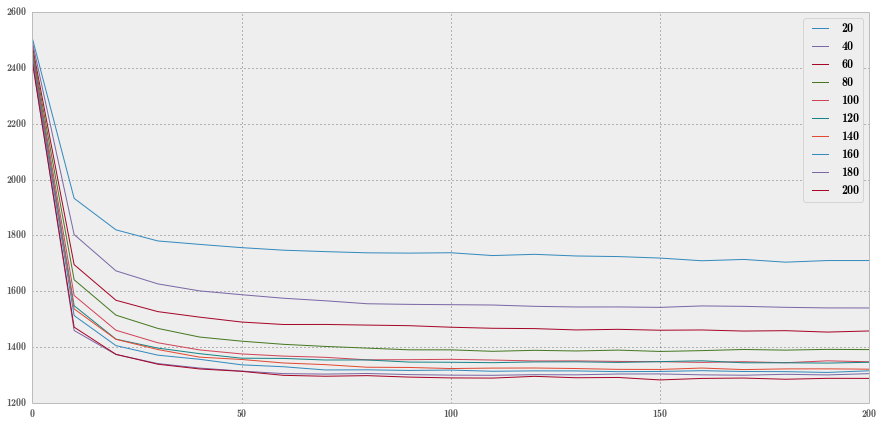

In [13]:
import os

results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/'

perplexity_topic = pd.read_csv(os.path.join(results_dir, 'perplexity_topic.csv'), index_col=0)
perplexity_topic.plot();

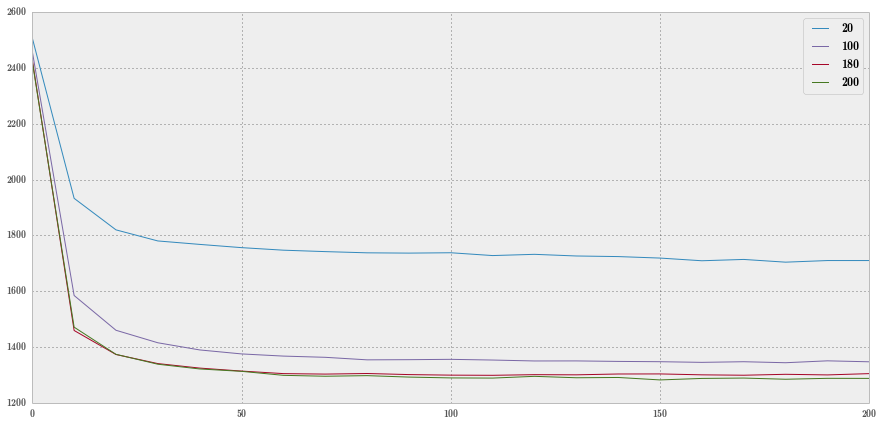

In [14]:
perplexity_topic[['20', '100', '180', '200']].plot();

### Opinion word perplexity

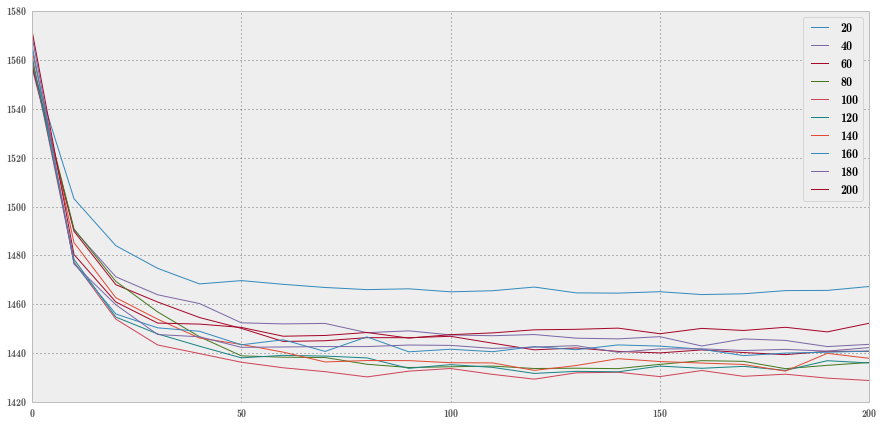

In [15]:
perplexity_opinion = pd.read_csv(os.path.join(results_dir, 'perplexity_opinion.csv'), index_col=0)
perplexity_opinion.plot();

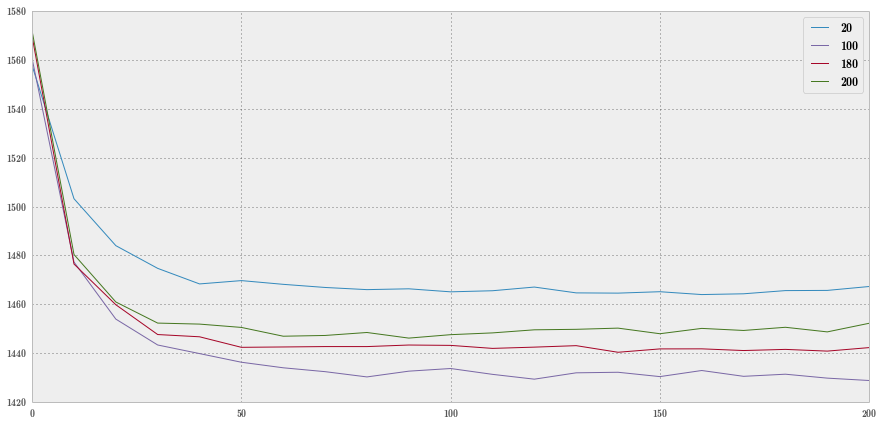

In [16]:
perplexity_opinion[['20', '100', '180', '200']].plot();

Voor topic perplexity is het optimale aantal topics 180. Voor opinion perplexity is het 100.

Wat verder opvalt is dat topic perplexity verder afneemt dan opinion perplexity. Dit heeft vast te maken met dat er veel nutteloze woorden in de opinion woorden zitten (de werkwoorden).

### Results for topics and opinions (nTopics = 100)

In [17]:
# load results
import glob
import os
import re

results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/'

# document topic matrix (theta)
theta = pd.read_csv(os.path.join(results_dir, 'theta_100.csv'), index_col=0)

# phi topic (transposed)
phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics_100.csv'), index_col=0, encoding='utf-8')

# phi opinion (transposed) per perspective
opinion_files = glob.glob('{}opinions_*.csv'.format(results_dir))
phis_opinion_t = {}
for f in opinion_files:
    m = re.match(r'.+opinions_(.+).csv', f)
    name = m.group(1).replace('_100', '')
    phis_opinion_t[name] = pd.read_csv(f, index_col=0, encoding='utf-8')

#### 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

However, because in our case one document consists of the minutes of a single meeting, we might see multiple topics per document. To improve this, we might reconsider making a dataset with a document per ``pm:topic`` instead of a document per document.

In [18]:
a = theta.copy().apply(max, axis=1)
a.sort(ascending=False)

print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
print 'Median weight of most important topic: ', a.median()

Mean weight of most important topic: 0.297432602382 (std: 0.139164873019)
Min and max of most important topic: min: 0.0495798319328, max: 0.709607171999
Median weight of most important topic:  0.278735994398


Line graph of the sorted topic weigths:

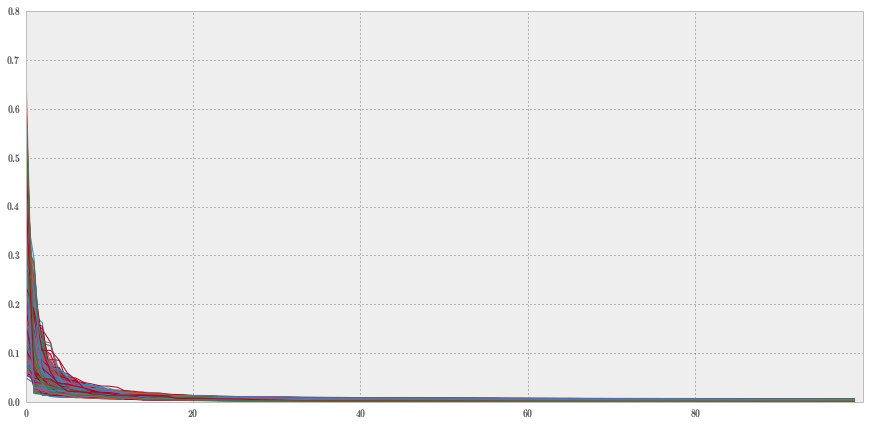

In [19]:
theta.copy().apply(lambda row:sorted(row)[::-1], axis=1).transpose().plot(legend=None);

#### Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

0      1
1    226
2    379
3    241
4    119
5     35
6     11
dtype: int64


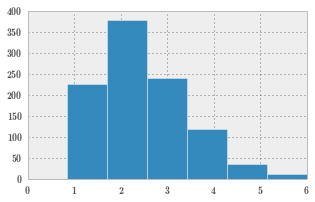

In [20]:
threshold = 0.05

topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
print topic_counts.value_counts(sort=False)
topic_counts.hist(bins=len(topic_counts.value_counts()), figsize=(5,3));

#### Topics

In [21]:
def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

In [22]:
for i in range(100):
    print show_topic(str(i))[['topic_{}'.format(i), 'opinion_{}_Government'.format(i), 'opinion_{}_Opposition'.format(i)]]

          topic_0 opinion_0_Government opinion_0_Opposition
0     rechtspraak         gerechtelijk          rechterlijk
1         rechter          rechterlijk               dienen
2       kwaliteit            betekenen                klein
3           kaart            nationaal         functioneren
4       rechtbank        onafhankelijk          organiseren
5           macht         functioneren         gerechtelijk
6  arrondissement            toezeggen               leiden
7       evaluatie                zelfs                 kort
8      herziening           waarborgen         ondersteunen
9     organisatie               kiezen               wijzen

[10 rows x 3 columns]
              topic_1 opinion_1_Government opinion_1_Opposition
0             bestuur         verschillend                 jong
1              eiland                zelfs          pensioneren
2       pensioenfonds               direct              vandaag
3          koninkrijk             openbaar               kiez